In [1]:
import pandas as pd
import numpy as np
import string

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import statsmodels as sm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_row', None)

In [3]:
df_orig = pd.read_csv('data/questions-train.csv', delimiter='\t')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


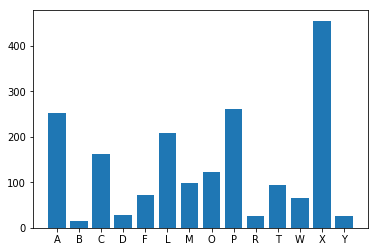

In [4]:
types = list(df_orig.groupby('type').size().index)
question_count = df_orig.groupby('type').size().values
fig, ax = plt.subplots()
ax.bar(range(len(types)), question_count)
plt.xticks(range(len(types)), types)
fig.show()

In [5]:
df_orig.shape

(1888, 2)

In [6]:
df_orig[df_orig['type']=='Y']

,type,questions
631,Y,What is the median age of cars in the U.S.?
695,Y,What is the median age at the time of marriage for grooms in New Jersey?
868,Y,Which age group in the U.S. has the highest suicide rate?
923,Y,What age group accounted for the most fatal auto accidents in New Jersey last year?
1005,Y,How old is the oldest player on the Somerset Patriots baseball team?
1121,Y,How old is the Pope?
1188,Y,At what age can I draw money out of a roth IRA?
1225,Y,What is the legal age of consent?
1287,Y,How old was Selena when she died?
1292,Y,How old was Jack Kennedy when he was elected President?


In [4]:
df_PLOT = pd.read_csv('data/questions-train_PLOT_only.csv', delimiter='\t')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


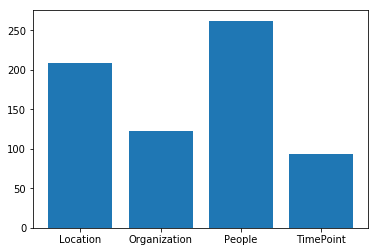

In [5]:
types = list(df_PLOT.groupby('type').size().index)
question_count = df_PLOT.groupby('type').size().values
fig, ax = plt.subplots()
ax.bar(range(len(types)), question_count)
plt.xticks(range(len(types)), types)
fig.show()

In [6]:
question_count

array([209, 122, 262,  93])

In [7]:
df_shub = pd.read_parquet('/Users/zirufan/Lucidworks/test_data/shub_qa_raw_nouns_verbs.parquet', engine='pyarrow')

In [8]:
df_shub.columns

Index(['q_id', 'a_id', 'project_label', 'subject', 'q_author', 'a_author',
       'question', 'answer', 'q_published', 'a_published', 'q_nouns_only',
       'q_verbs_only', 'a_nouns_only', 'a_verbs_only'],
      dtype='object')

### Only 64K unique questions

In [9]:
len(df_shub['question'].unique())

64189

## Text Mining: find more questions for training

In [10]:
import spacy
spc_nlp = spacy.load('en')

In [11]:
# test
text = 'Which poet was born in 1572 and appointed Dean of St. Paul\'s Cathedral in 1621?'
pos = [token.pos_ for token in spc_nlp(text)]
print ([a+'('+b+')' for a, b in zip(text.split(' '), pos)])

['Which(ADJ)', 'poet(NOUN)', 'was(VERB)', 'born(VERB)', 'in(ADP)', '1572(NUM)', 'and(CCONJ)', 'appointed(VERB)', 'Dean(PROPN)', 'of(ADP)', 'St.(PROPN)', "Paul's(PROPN)", 'Cathedral(PART)', 'in(PROPN)', '1621?(ADP)']


In [12]:
df_PLOT.shape

(686, 2)

#### Add POS annotation to each word in TT training questions. Then one can examine the mixed pattern and generate regex

In [14]:
df_PLOT['pos'] = df_PLOT['questions'].apply(lambda x: [' '.join([token.pos_ for token in spc_nlp(s.text)]) for s in spc_nlp(x).sents][0])


In [15]:
df_PLOT['q_pos'] = df_PLOT.apply(lambda x: ' '.join([a+'('+b+')' for a,b in zip(x['questions'].split(' '), x['pos'].split(' '))]), axis=1)


In [16]:
df_PLOT['q_pos']

0      Which(ADJ) French(ADJ) monarch(NOUN) reinstated(VERB) the(DET) divine(ADJ) right(NOUN) of(ADP) the(DET) monarchy(NOUN) to(ADP) France(PROPN) and(CCONJ) was(VERB) known(VERB) as(ADP) `The(PUNCT) Sun(DET) King'(PROPN) because(PROPN) of(PUNCT) the(ADP) splendour(ADP) of(DET) his(NOUN) reign?(ADP)                                                                                                                                                                                                              
1      Which(ADJ) eponymous(ADJ) hero(NOUN) of(ADP) a(DET) work(NOUN) first(ADV) published(VERB) in(ADP) 1902(NUM) was(VERB) warned(VERB) of(ADP) the(DET) dangers(NOUN) lurking(VERB) in(ADP) a(DET) nearby(ADJ) garden(NOUN) with(ADP) the(DET) words(NOUN) `Your(PUNCT) father(ADJ) had(NOUN) an(VERB) accident(DET) there;(NOUN) he(ADV) was(PUNCT) put(PRON) in(VERB) a(VERB) pie(ADP) by(DET) Mr.(NOUN) McGregor'?(ADP)                                                                               

In [17]:
df_shub.columns

Index(['q_id', 'a_id', 'project_label', 'subject', 'q_author', 'a_author',
       'question', 'answer', 'q_published', 'a_published', 'q_nouns_only',
       'q_verbs_only', 'a_nouns_only', 'a_verbs_only'],
      dtype='object')

In [18]:
# Annotate SHUB question text with POS
#df_shub_new = df_shub[['subject','question','answer']]
df_shub_new = df_shub[['question']]

In [19]:
df_shub_new = df_shub_new.drop_duplicates()

In [20]:
df_shub_new.shape

(64189, 1)

In [22]:
# generate (sentence, pos) tuple so that once a pos pattern is matched , the corresponding sentence can be retrieved
batch1 = df_shub_new[:1000]
batch1['q_pos'] = batch1['question'].apply(lambda x: [' '.join([term+'('+token.pos_+')' for term, token in zip(s.text.split(' '), spc_nlp(s.text))]) for s in spc_nlp(x).sents])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
import re
which = re.compile(r'^which\(ADJ\) \S+\(NOUN\)', re.IGNORECASE)
who = re.compile(r'^who\(NOUN\)(?: \S+\(NOUN\))* \S+\(VERB\)', re.IGNORECASE)
what_1 = re.compile(r'^what\(NOUN\)(?: \S+\(NOUN\))* \S+\(VERB\)(?: \S+\(PRON\))*', re.IGNORECASE)
what_2 = re.compile(r'^what\(ADJ\)(?: \S+\(ADJ\))*(?: \S+\(NOUN\))+ \S+\(VERB\)', re.IGNORECASE)
when = re.compile(r'^when\(ADV\) \S+\(VERB\)(?: \S+\(DET\)|\S+\(NOUN\)|\S+\(PROPN\))*', re.IGNORECASE)
where_1 = re.compile(r'^where\(ADV\) \S+\(VERB\)', re.IGNORECASE)
where_2 = re.compile(r'^where\(ADV\) \S+\(ADP\) (?:\S+\(DET\)|\S+\(PROPN\))*', re.IGNORECASE)
other = re.compile(r'^which|^what|^when|^who|^where', re.IGNORECASE)
#why = 
#how = 

regex_pattern_list = [which, who, what_1, what_2, when, where_1, where_2, other]

In [27]:
# test
s = 'What(ADJ) car(NOUN) company(NOUN) makes(VERB)'
s2 = 'What(NOUN) can(VERB) I(PRON) do(VERB)'
match = what_1.search(s2)
print (match.group(0))

What(NOUN) can(VERB) I(PRON)


In [28]:
# clear \n
batch1['q_pos_new'] = batch1['q_pos'].apply(lambda x: [i.replace('\n','') for i in x])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
def search_question(sententce_list, regex_pattern_list):
    results = {}
    for r in regex_pattern_list:
        result = []
        for s in sententce_list:
            match = r.search(s)
            if match is not None:
                result.append(s)
        if len(result) > 0:
            results[r.pattern[:10]] = result
    if len(results.keys()) > 0:
        return results
    return None

In [30]:
#test = batch1['q_pos_new'][:100].apply(lambda x: search_question(x, regex_pattern_list))
batch1['captured_question'] = batch1['q_pos_new'].apply(lambda x: search_question(x, regex_pattern_list))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
batch1[~batch1['captured_question'].isnull()]['captured_question'][:100]

0       {'^what\(NOU': ['What(NOUN) can(VERB) I(PRON) do?(VERB)'], '^which|^wh': ['What(NOUN) can(VERB) I(PRON) do?(VERB)']}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            